# Анализ убытков приложения ProcrastinatePRO+

**Цель** - выявить причины убытков компании, несмотря на значительные инвестиции в рекламу, и разработать стратегии для достижения прибыльности.

**Входные данные**:таблицы с данными о визитах, заказах,расходах

**План**:

1. Загрузка и предобработка данных

2. Ввод функций для расчёта и анализа LTV, ROI, удержания и конверсии

3. Исследовательский анализ данных

4. Маркетинг

5. Оцените окупаемость рекламы

6. Общий вывод

## Загрузка и предобработка данных

### Загрузка данных

**Импортируем файл с данными и изучим общую информацию**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Названия столбцов

**Переименуем названия столбцов**

In [6]:
visits = visits.rename(
columns={
'User Id': 'user_id',
'Region': 'region',
'Device': 'device',
'Channel': 'channel', 
'Session Start': 'session_start',
'Session End': 'session_end',}
)

In [7]:
orders = orders.rename(
columns={
'User Id': 'user_id',
'Event Dt': 'event_dt',
'Revenue': 'revenue',}
)

In [8]:
costs = costs.rename(
columns={
'Channel': 'channel',}
)

### Проверка дубликатов и изменение типа данных столбцов

**Проверим есть ли в таблицах явные дубликаты**

In [9]:
visits.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.duplicated().sum()

0

Явные дубликаты отсутствуют

**Проверим есть ли в таблицах неявные дубликаты**

In [12]:
visits['region'] = visits['region'].str.lower()
visits['device'] = visits['device'].str.lower()
visits['channel'] = visits['channel'].str.lower()

In [13]:
visits['region'].sort_values().unique()

array(['france', 'germany', 'uk', 'united states'], dtype=object)

In [14]:
visits.duplicated().sum()

0

In [15]:
visits.duplicated(subset=['user_id', 'session_start']).sum()

0

In [16]:
costs['channel'] = costs['channel'].str.lower()

In [17]:
costs['channel'].sort_values().unique()

array(['adnonsense', 'faceboom', 'lambdamediaads', 'leapbob',
       'mediatornado', 'opplecreativemedia', 'rocketsuperads', 'tiptop',
       'wahoonetbanner', 'yrabbit'], dtype=object)

In [18]:
costs.duplicated().sum()

0

In [19]:
visits['region'] = visits['region'].str.title()
visits['device'] = visits['device'].str.title()
visits['channel'] = visits['channel'].str.title()
costs['channel'] = costs['channel'].str.title()

Неявные дубликаты отсутствуют 

**Изменим тип данных столбцов**

In [20]:
visits.dtypes 

user_id           int64
region           object
device           object
channel          object
session_start    object
session_end      object
dtype: object

In [21]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [22]:
orders.dtypes

user_id       int64
event_dt     object
revenue     float64
dtype: object

In [23]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [24]:
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

In [25]:
costs['dt'] = pd.to_datetime(costs['dt'])

### Обработка пропусков в таблице

**Проверим таблицы на пропуски**

In [26]:
a = visits.isna().sum()
a

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [27]:
b = orders.isna().sum()
b

user_id     0
event_dt    0
revenue     0
dtype: int64

In [28]:
c = costs.isna().sum()
c

dt         0
channel    0
costs      0
dtype: int64

Пропусков нет 

**Не обнаружено значительных недостатков в таблицах.**

**Исправлены наименования столбцов, а столбцы с датами и временем были корректно преобразованы к соответствующему типу.** 

**В данных отсутствуют дубликаты и пропущенные значения.**

## Ввод функций для расчёта и анализа (LTV, ROI, удержания и конверсии)

Напишем функции для вычисления значений метрик:LTV, ROI, удержания и конверсии

**Функция для создания профилей пользователей** get_profiles()

In [29]:
def get_profiles(sessions):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    # от англ. first timestamp — первая временная отметка
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'device': 'first', 'region': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    return profiles

**Функция для подсчёта Retention Rate** get_retention()

In [30]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта конверсии** get_conversion()

In [31]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта LTV** get_ltv()

In [32]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Напишем функции для построения графиков:

**Функция для сглаживания данных** filter_data()

In [33]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для построения графика Retention Rate** plot_retention()

In [34]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для построения графика конверсии** plot_conversion()

In [35]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и ROI** plot_ltv_roi

In [36]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей и дата привлечения 

Cоставим профили пользователей и определим минимальную и максимальную дату привлечения пользователей.

In [37]:
profiles = get_profiles(visits)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month
0,599326,2019-05-07 20:58:57,Faceboom,Mac,United States,2019-05-07,2019-05-01
1,4919697,2019-07-09 12:46:07,Faceboom,Iphone,United States,2019-07-09,2019-07-01
2,6085896,2019-10-01 09:58:33,Organic,Iphone,France,2019-10-01,2019-10-01
3,22593348,2019-08-22 21:35:48,Adnonsense,Pc,Germany,2019-08-22,2019-08-01
4,31989216,2019-10-02 00:07:44,Yrabbit,Iphone,United States,2019-10-02,2019-10-01


In [38]:
profiles.agg({'dt': ['min', 'max']})

,dt
min,2019-05-01
max,2019-10-27


После применения функции в таблице профилей присутствуют столбцы: индефикатор пользователя, дата и время первого посещение, рекламный канал, из которого пользователь перешёл на сайт, дата первого посещения, первый день месяца, в который это посещение произошло.

**Минимальная дата** для анализа 1 мая 2019.

**Максимальная дата** анализа 27 октября 2019.

Минимальная и максимальная даты привлечения пользователей - 1 мая 2019 года и 27 октября 2019 года соответственно. Это совпадает с указанными в задании рамками.

### Доля платящих пользователей из каждой страны

Определим из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [39]:
profiles['region'].unique()

array(['United States', 'France', 'Germany', 'Uk'], dtype=object)

In [40]:
# Общее количество пользователей по странам 
total_users = profiles.groupby('region')['user_id'].nunique().sort_values(ascending=False)
total_users

region
United States    100002
Uk                17575
France            17450
Germany           14981
Name: user_id, dtype: int64

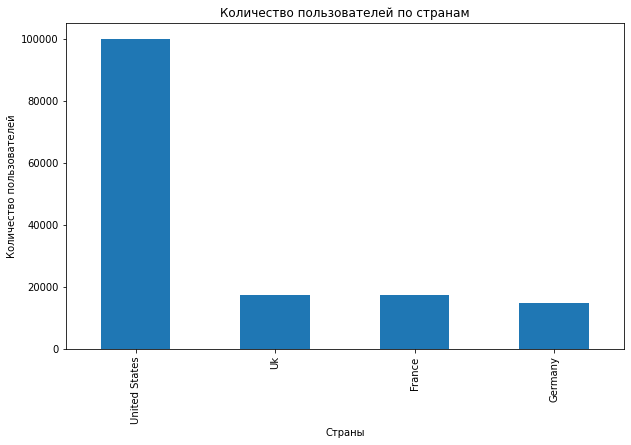

In [41]:
# Создание столбчатого графика
total_users.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Количество пользователей по странам')
plt.xlabel('Страны')
plt.ylabel('Количество пользователей')

# Отображение графика
plt.show()

In [42]:
# Определение платящих пользователей
paying_users = orders['user_id'].unique()

# Фильтрация пользователей, которые совершили покупки
paying_users = profiles[profiles['user_id'].isin(paying_users)]
paying_users_data = paying_users.groupby('region')['user_id'].nunique().sort_values(ascending=False)
paying_users_data


region
United States    6902
Uk                700
France            663
Germany           616
Name: user_id, dtype: int64

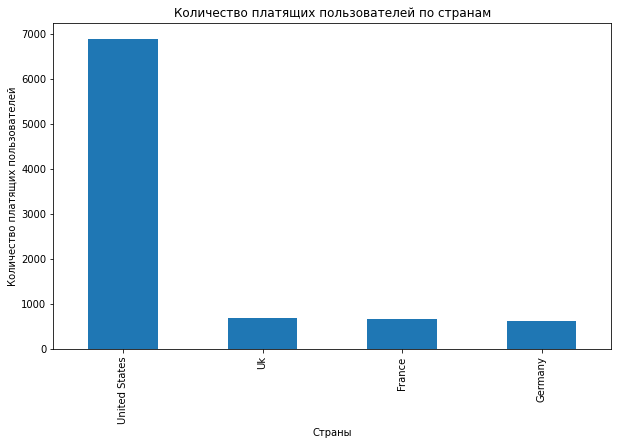

In [43]:
# Создание столбчатого графика
paying_users_data.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Количество платящих пользователей по странам')
plt.xlabel('Страны')
plt.ylabel('Количество платящих пользователей')

# Отображение графика
plt.show()

**Пользователи приходят в приложение из стран** США, Великобритания, Франция, Германия.

**Больше всего платящих пользователей** приходится на США

Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [44]:
# Объединение данных
merged_data = pd.merge(total_users, paying_users_data, on='region')
merged_data = merged_data.rename(columns={'user_id_x':'total_users','user_id_y': 'paying_users'})
merged_data['share_paying'] = round((merged_data['paying_users']/merged_data['total_users']),3)
merged_data.sort_values(by='share_paying',ascending=False)

,total_users,paying_users,share_paying
region,,,
United States,100002,6902,0.069
Germany,14981,616,0.041
Uk,17575,700,0.040
France,17450,663,0.038


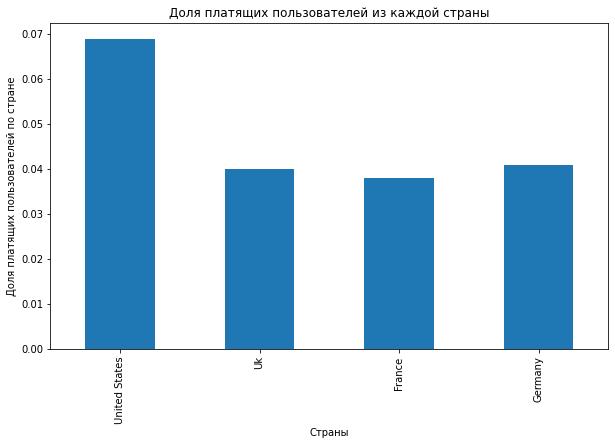

In [45]:
# Создание столбчатого графика
merged_data['share_paying'].plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Доля платящих пользователей из каждой страны')
plt.xlabel('Страны')
plt.ylabel('Доля платящих пользователей по стране')

# Отображение графика
plt.show()

**Наибольшая доля платящих пользователей из США.**

В 3 других страннах (Германия, Великобритания, Франция) доля платящих почти одинаковая

### Устройства, которые  предпочитают платящие пользователи

Определим какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [46]:
profiles.groupby('device')['user_id'].nunique().sort_values(ascending=False)

device
Iphone     54479
Android    35032
Pc         30455
Mac        30042
Name: user_id, dtype: int64

In [47]:
profiles.groupby('user_id')['device'].count().median()

1.0

In [48]:
visits.groupby('user_id')['device'].count().median()

2.0

Берем данные из таблицы профелей, так как в таблице visits данные дублируется из-за группировки по device и считается уникальные пользователи именно по device. В табл profiles только один пользователь сохранен с его первым посещением

In [49]:
#общ кол-во пользователей по устройству
total_users_device = profiles.groupby('device')['user_id'].nunique().sort_values(ascending=False)
total_users_device

device
Iphone     54479
Android    35032
Pc         30455
Mac        30042
Name: user_id, dtype: int64

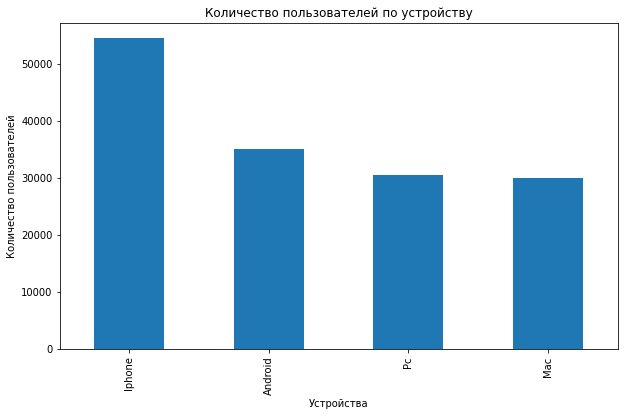

In [50]:
# Создание столбчатого графика
total_users_device.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Количество пользователей по устройству')
plt.xlabel('Устройства')
plt.ylabel('Количество пользователей')

# Отображение графика
plt.show()

In [51]:
profiles['device'].unique()

array(['Mac', 'Iphone', 'Pc', 'Android'], dtype=object)

In [52]:
paying_users_device = paying_users.groupby('device')['user_id'].nunique().sort_values(ascending=False)
paying_users_device

device
Iphone     3382
Android    2050
Mac        1912
Pc         1537
Name: user_id, dtype: int64

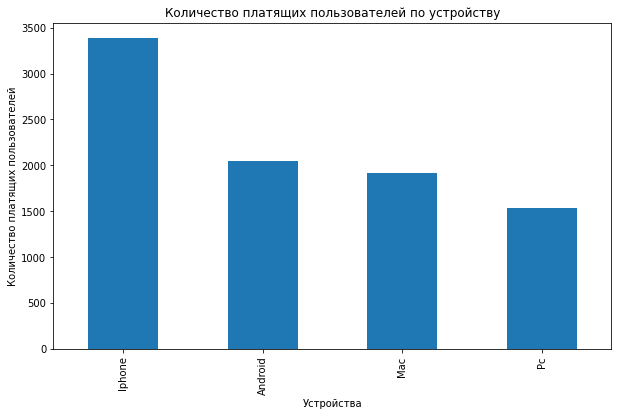

In [53]:
# Создание столбчатого графика
paying_users_device.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Количество платящих пользователей по устройству')
plt.xlabel('Устройства')
plt.ylabel('Количество платящих пользователей')

# Отображение графика
plt.show()

**Пользователи пользуются** Iphone, Mac, Android, Pc.

**Платящие пользователи предпочитают Iphone**

Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [54]:
# Объединение данных
merged_data_device = pd.merge(total_users_device, paying_users_device, on='device')
merged_data_device = merged_data_device.rename(columns={'user_id_x':'total_users','user_id_y': 'paying_users'})
merged_data_device['share_paying'] = round((merged_data_device['paying_users']/merged_data_device['total_users']),3)
merged_data_device.sort_values(by='share_paying',ascending=False)

,total_users,paying_users,share_paying
device,,,
Mac,30042,1912,0.064
Iphone,54479,3382,0.062
Android,35032,2050,0.059
Pc,30455,1537,0.050


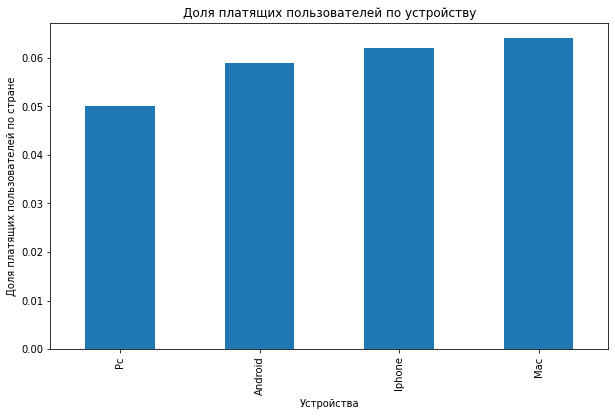

In [55]:
# Создание столбчатого графика
merged_data_device['share_paying'].sort_values().plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Доля платящих пользователей по устройству')
plt.xlabel('Устройства')
plt.ylabel('Доля платящих пользователей по стране')

# Отображение графика
plt.show()

**Доля платящих пользователей больше у Mac**

###  Доля платящих пользователей для каждого канала привлечения

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 

Определим общие количество привлеченных пользователей по каналу привлечения

In [56]:
channel_users = profiles.groupby('channel')['user_id'].nunique().sort_values(ascending = False)
channel_users

channel
Organic               56439
Faceboom              29144
Tiptop                19561
Opplecreativemedia     8605
Leapbob                8553
Wahoonetbanner         8553
Rocketsuperads         4448
Mediatornado           4364
Yrabbit                4312
Adnonsense             3880
Lambdamediaads         2149
Name: user_id, dtype: int64

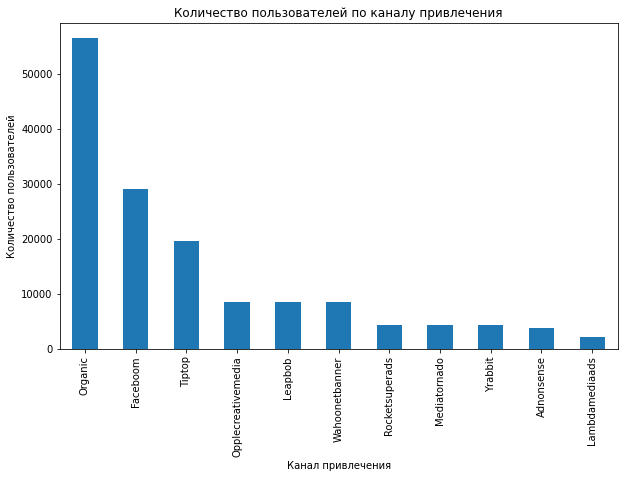

In [57]:
# Создание столбчатого графика
channel_users.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Количество пользователей по каналу привлечения')
plt.xlabel('Канал привлечения')
plt.ylabel('Количество пользователей')

# Отображение графика
plt.show()

**Больше всего пользователей пришло самостаятельно**, без рекламы.

**По количеству пользователей привлеченных рекламой лидирует Faceboom**

Определим общие количество привлеченных ПЛАТЯЩИХ пользователей по каналу привлечения

In [58]:
paying_users_channel = paying_users.groupby('channel')['user_id'].nunique().sort_values(ascending=False)
paying_users_channel

channel
Faceboom              3557
Tiptop                1878
Organic               1160
Wahoonetbanner         453
Adnonsense             440
Rocketsuperads         352
Leapbob                262
Opplecreativemedia     233
Lambdamediaads         225
Yrabbit                165
Mediatornado           156
Name: user_id, dtype: int64

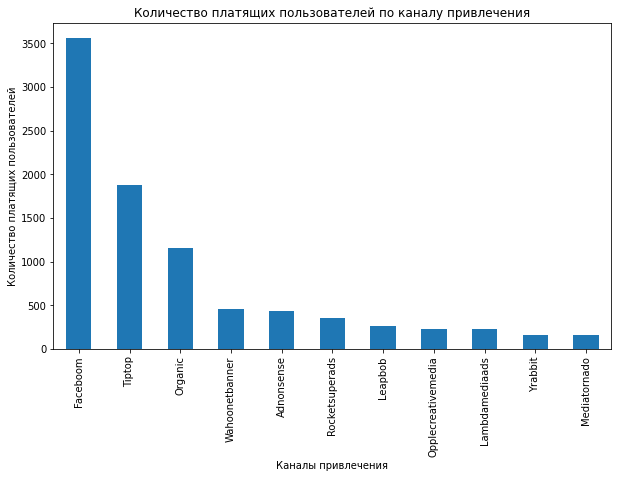

In [59]:
# Создание столбчатого графика
paying_users_channel.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Количество платящих пользователей по каналу привлечения')
plt.xlabel('Каналы привлечения')
plt.ylabel('Количество платящих пользователей')

# Отображение графика
plt.show()

**По количеству ПЛАТЯЩИХ пользователей привлеченных рекламой лидирует Faceboom**

Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [60]:
# Объединение данных
merged_data_channel = pd.merge(channel_users, paying_users_channel, on='channel')
merged_data_channel = merged_data_channel.rename(columns={'user_id_x':'total_users','user_id_y': 'paying_users'})
merged_data_channel['share_paying'] = round((merged_data_channel['paying_users']/merged_data_channel['total_users']),3)
merged_data_channel = merged_data_channel.sort_values(by='share_paying')
merged_data_channel.sort_values(by = 'share_paying')

,total_users,paying_users,share_paying
channel,,,
Organic,56439,1160,0.021
Opplecreativemedia,8605,233,0.027
Leapbob,8553,262,0.031
Mediatornado,4364,156,0.036
Yrabbit,4312,165,0.038
Wahoonetbanner,8553,453,0.053
Rocketsuperads,4448,352,0.079
Tiptop,19561,1878,0.096
Lambdamediaads,2149,225,0.105


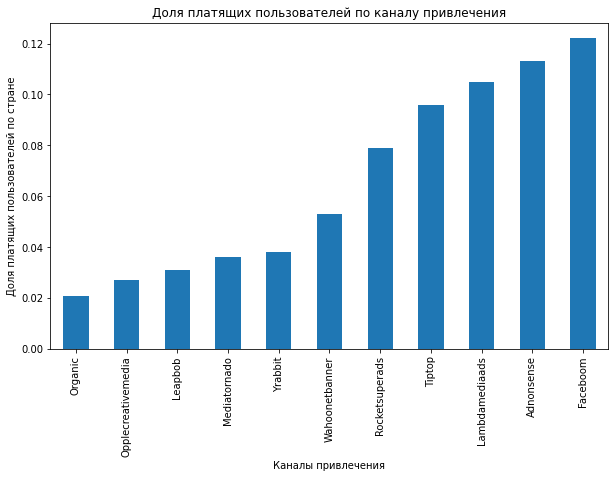

In [61]:
# Создание столбчатого графика
merged_data_channel['share_paying'].plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Доля платящих пользователей по каналу привлечения')
plt.xlabel('Каналы привлечения')
plt.ylabel('Доля платящих пользователей по стране')

# Отображение графика
plt.show()

**Больше всего доля платящих пользователей у Faceboom** 

По количеству привлеченных пользоватей и количеству платящих пользователей этот канал тоже на первом месте

## Маркетинг

### Общая сумма расходов на маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [62]:
# примем условные единицы за доллары
marketing_costs = round(costs['costs'].sum(),2)
marketing_costs

105497.3

**На маркетинг компания потратила 105 497.3 долларов**

### Траты  по рекламным источникам

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [63]:
channel_costs = (round(costs.groupby('channel')['costs'].sum(),2)).sort_values(ascending = False)
channel_costs

channel
Tiptop                54751.30
Faceboom              32445.60
Wahoonetbanner         5151.00
Adnonsense             3911.25
Opplecreativemedia     2151.25
Rocketsuperads         1833.00
Leapbob                1797.60
Lambdamediaads         1557.60
Mediatornado            954.48
Yrabbit                 944.22
Name: costs, dtype: float64

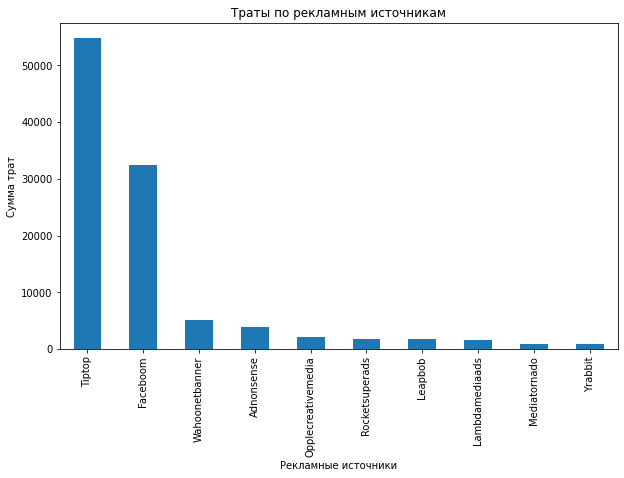

In [64]:
# Создание столбчатого графика
channel_costs.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Траты по рекламным источникам')
plt.xlabel('Рекламные источники')
plt.ylabel('Сумма трат')

# Отображение графика
plt.show()

**Больше всего компания потратила на пользователей из источника** : Tiptop,Faceboom

In [65]:
sum_costs = round(costs['costs'].sum(),2)
sum_costs

105497.3

In [66]:
# Создание DataFrame
channel_costs = pd.DataFrame({
    'channel': ['Tiptop', 'Faceboom', 'Wahoonetbanner', 'Adnonsense', 'Opplecreativemedia', 
                'Rocketsuperads', 'Leapbob', 'Lambdamediaads', 'Mediatornado', 'Yrabbit'],
    'costs': [54751.30, 32445.60, 5151.00, 3911.25, 2151.25, 1833.00, 1797.60, 1557.60, 954.48, 944.22]
})

# Подсчет общей суммы расходов
sum_costs = channel_costs['costs'].sum()

# Деление расходов каждого канала на общую сумму расходов
channel_costs['normalized_costs'] = channel_costs['costs'] / sum_costs

print(channel_costs.sort_values(by = 'normalized_costs'))

              channel     costs  normalized_costs
9             Yrabbit    944.22          0.008950
8        Mediatornado    954.48          0.009047
7      Lambdamediaads   1557.60          0.014764
6             Leapbob   1797.60          0.017039
5      Rocketsuperads   1833.00          0.017375
4  Opplecreativemedia   2151.25          0.020392
3          Adnonsense   3911.25          0.037074
2      Wahoonetbanner   5151.00          0.048826
1            Faceboom  32445.60          0.307549
0              Tiptop  54751.30          0.518983


**Больше всего компания потратила на пользователей из источника** : на Tiptop и Faceboom. На  Tiptop ушел 51% от всех рекламных трат, на Faceboom 30 процентов от всего рекламного бюджета.

### Графики с визуализацией динамики изменения расходов

Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. 

In [67]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs.head()

,dt,channel,costs,week,month
0,2019-05-01,Faceboom,113.3,18,5
1,2019-05-02,Faceboom,78.1,18,5
2,2019-05-03,Faceboom,85.8,18,5
3,2019-05-04,Faceboom,136.4,18,5
4,2019-05-05,Faceboom,122.1,18,5


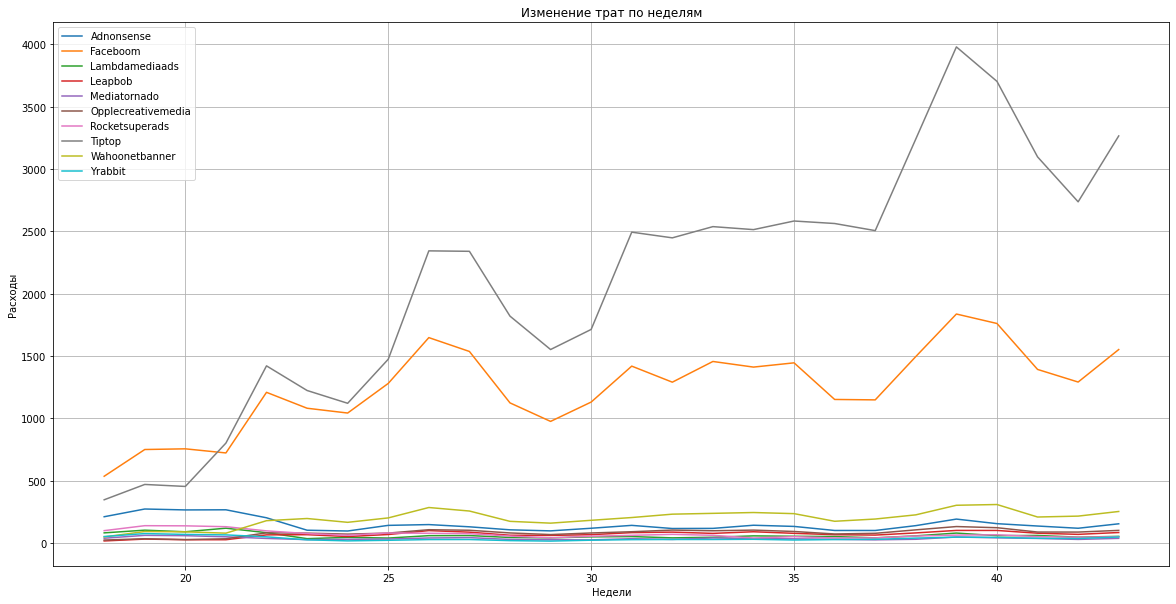

In [68]:
# изменений трат по неделям
costs.pivot_table(
    index='week',
    columns='channel',
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(20, 10), grid=True)

plt.title('Изменение трат по неделям')
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.legend()
plt.show()

In [69]:
# создадим таблицу сгруппированную по сумме расход на каждый источник по неделям
costs_1 = costs.pivot_table(
    index='week',
    columns='channel',
    values='costs',  
    aggfunc='sum')
costs_1

channel,Adnonsense,Faceboom,Lambdamediaads,Leapbob,Mediatornado,Opplecreativemedia,Rocketsuperads,Tiptop,Wahoonetbanner,Yrabbit
week,,,,,,,,,,
18,211.05,535.7,81.6,16.80,38.64,24.00,99.450,347.0,49.2,52.20
19,273.00,750.2,103.2,31.71,61.68,34.50,139.230,470.0,92.4,75.90
20,265.65,755.7,90.4,26.67,59.04,27.50,138.060,454.0,90.0,69.30
21,266.70,722.7,119.2,26.67,50.16,34.25,131.040,801.8,79.2,65.40
22,202.65,1208.9,83.2,65.52,36.96,81.75,97.695,1421.2,179.4,49.80
23,102.90,1081.3,35.2,66.99,27.60,79.50,76.050,1223.6,196.8,25.80
24,96.60,1042.8,45.6,52.29,29.76,71.50,63.180,1121.0,166.2,17.46
25,141.75,1280.4,40.0,68.46,32.16,79.75,80.730,1474.4,201.6,22.14
26,148.05,1647.8,59.2,99.75,40.56,107.00,78.260,2343.6,285.0,27.90


In [70]:
# цикл для расчета отношения между неделями 43 и 18 для каждого канала 
for channel in costs_1.columns:
    # Проверка наличия данных для недель 43 и 18
    if 43 in costs_1.index and 18 in costs_1.index:
        # Расчет отношения между неделями 43 и 18 для каждого канала
        ratio = costs_1.loc[43, channel] / costs_1.loc[18, channel]
        print(f"{channel} {round(ratio,2)}")
    else:
        print(f"Данные за неделю 43 или 18 отсутствуют для канала {channel}")


Adnonsense 0.73
Faceboom 2.9
Lambdamediaads 0.66
Leapbob 5.02
Mediatornado 0.97
Opplecreativemedia 4.23
Rocketsuperads 0.51
Tiptop 9.41
Wahoonetbanner 5.15
Yrabbit 0.93


In [71]:
# создадим таблицу отношения расходов между неделями 43 и 18 для каждого канала по возрастанию

data_ratio = {
    'Channel': ['Adnonsense', 'Faceboom', 'Lambdamediaads', 'Leapbob', 'Mediatornado', 'Opplecreativemedia', 'Rocketsuperads', 'Tiptop', 'Wahoonetbanner', 'Yrabbit'],
    'Ratio': [0.73, 2.9, 0.66, 5.02, 0.97, 4.23, 0.51, 9.41, 5.15, 0.93]
}

# Создание DataFrame из данных
data_ratio = pd.DataFrame(data_ratio)

# Вывод DataFrame
print(data_ratio.sort_values(by = 'Ratio',ascending = False))

              Channel  Ratio
7              Tiptop   9.41
8      Wahoonetbanner   5.15
3             Leapbob   5.02
5  Opplecreativemedia   4.23
1            Faceboom   2.90
4        Mediatornado   0.97
9             Yrabbit   0.93
0          Adnonsense   0.73
2      Lambdamediaads   0.66
6      Rocketsuperads   0.51


**Расходы на пользователей существенно растут у Tiptop с каждой неделей.** 

На втором месте по графику кажется что это Faceboom, но после расчета соотношения роста расходов между неделями 43 и 18 для каждого канала становится ясно что на втором месте канал Wahoonetbanner

Визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

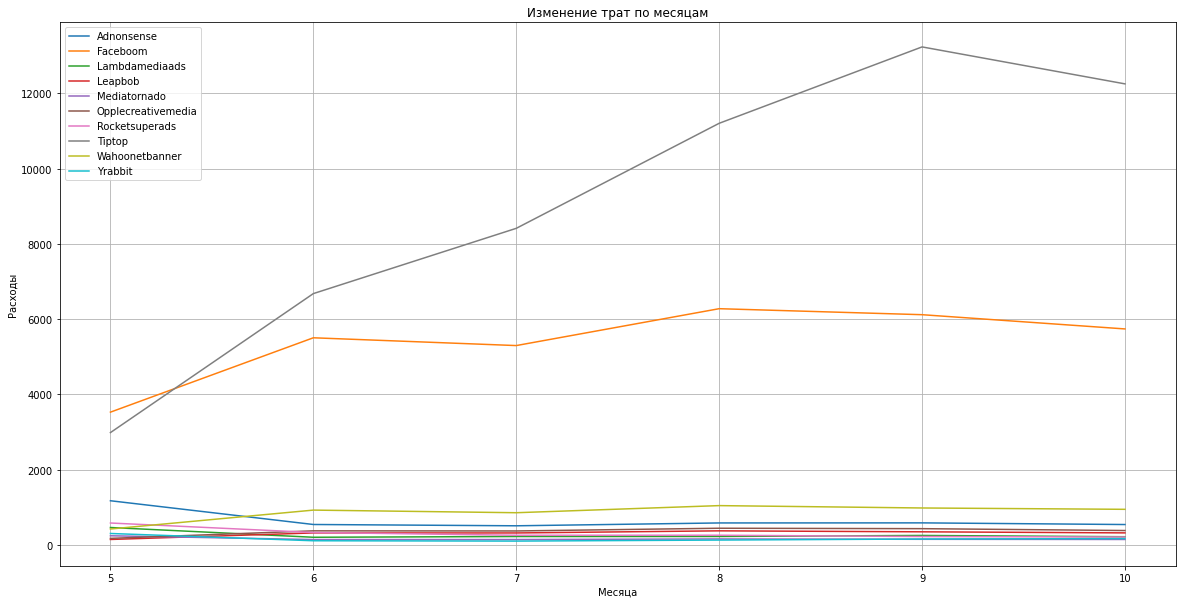

In [72]:
# изменений трат во времени
costs.pivot_table(
    index='month',
    columns='channel',
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(20, 10), grid=True)

plt.title('Изменение трат по месяцам')
plt.xlabel('Месяца')
plt.ylabel('Расходы')
plt.legend()
plt.show()

In [73]:
# создадим таблицу сгруппированную по сумме расход на каждый источник по месяцам
costs_month = costs.pivot_table(
    index='month',
    columns='channel',
    values='costs',  
    aggfunc='sum')
costs_month

channel,Adnonsense,Faceboom,Lambdamediaads,Leapbob,Mediatornado,Opplecreativemedia,Rocketsuperads,Tiptop,Wahoonetbanner,Yrabbit
month,,,,,,,,,,
5,1169.70,3524.4,458.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70
6,538.65,5501.1,199.2,314.58,138.00,370.00,325.715,6675.6,921.0,106.20
7,504.00,5294.3,219.2,313.53,138.48,366.50,252.070,8410.2,851.4,97.38
8,579.60,6274.4,220.0,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74
9,581.70,6114.9,247.2,343.98,144.72,427.75,218.400,13232.5,977.4,152.79
10,537.60,5736.5,213.6,315.42,140.16,378.00,205.725,12250.0,942.0,163.41


In [74]:
# цикл для расчета отношения между месяцами 10 и 5 для каждого канала 
for channel in costs_month.columns:
    # Проверка наличия данных для месяца 10 и 5
    if 10 in costs_month.index and 5 in costs_month.index:
        # Расчет отношения между неделями 43 и 18 для каждого канала
        ratio = costs_month.loc[10, channel] / costs_month.loc[5, channel]
        print(f"{channel} {round(ratio,2)}")
    else:
        print(f"Данные за месяц 10 или 5 отсутствуют для канала {channel}")


Adnonsense 0.46
Faceboom 1.63
Lambdamediaads 0.47
Leapbob 2.25
Mediatornado 0.59
Opplecreativemedia 2.23
Rocketsuperads 0.36
Tiptop 4.11
Wahoonetbanner 2.25
Yrabbit 0.55


In [75]:
# создадим таблицу отношения расходов между месяцами 10 и 5 для каждого канала по возрастанию

data_ratio_month = {
    'Channel':  ['Adnonsense', 'Faceboom', 'Lambdamediaads', 'Leapbob', 'Mediatornado', 'Opplecreativemedia', 'Rocketsuperads', 'Tiptop', 'Wahoonetbanner', 'Yrabbit'],
    'Ratio': [0.46, 1.63, 0.47, 2.25, 0.59, 2.23, 0.36, 4.11, 2.25, 0.55]
}

# Создание DataFrame из данных
data_ratio_month = pd.DataFrame(data_ratio_month)

# Вывод DataFrame
print(data_ratio_month.sort_values(by = 'Ratio',ascending = False))

              Channel  Ratio
7              Tiptop   4.11
3             Leapbob   2.25
8      Wahoonetbanner   2.25
5  Opplecreativemedia   2.23
1            Faceboom   1.63
4        Mediatornado   0.59
9             Yrabbit   0.55
2      Lambdamediaads   0.47
0          Adnonsense   0.46
6      Rocketsuperads   0.36


**Расходы на пользователей существенно растут у Tiptop с каждым месяцем.** 

На втором месте по графику кажется что это Faceboom, но после расчета соотношения роста расходов между меясцами 10 и 5 для каждого канала становится ясно что на втором месте канал Wahoonetbanner и Leapbob

### Стоимость привлечения одного пользователя из каждого источника (CAC)

Определим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

До этого мы написали функцию для создания профилей пользователей (get_profiles) немного модернизируем ее чтоб она выводила профили с CAC

In [76]:
# добавляем параметр ad_costs — траты на рекламу
def get_profiles(sessions, orders, ad_costs):
    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [77]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = costs['dt'].dt.date

profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,Faceboom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,Faceboom,Iphone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,Organic,Iphone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,Adnonsense,Pc,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,Yrabbit,Iphone,United States,2019-10-02,2019-10-01,False,0.230769


In [78]:
channel_stat = profiles.groupby('channel')['acquisition_cost'].mean()
channel_stat = round(channel_stat.sort_values(ascending=False),2)

channel_stat

channel
Tiptop                2.80
Faceboom              1.11
Adnonsense            1.01
Lambdamediaads        0.72
Wahoonetbanner        0.60
Rocketsuperads        0.41
Opplecreativemedia    0.25
Yrabbit               0.22
Mediatornado          0.22
Leapbob               0.21
Organic               0.00
Name: acquisition_cost, dtype: float64

Рассчитаем средний CAC на одного пользователя для всего проекта, так увидим на сколько выше среднего САС у популярных каналов.

In [79]:
channel_stat_mean = profiles['acquisition_cost'].mean()
channel_stat_mean = round(channel_stat_mean,2)

channel_stat_mean

0.7

In [80]:
# Данные из Series channel_stat
data = {
    'channel': ['Tiptop', 'Faceboom', 'Adnonsense', 'Lambdamediaads', 'Wahoonetbanner', 
                'Rocketsuperads', 'Opplecreativemedia', 'Yrabbit', 'Mediatornado', 'Leapbob', 'Organic'],
    'value': [2.80, 1.11, 1.01, 0.72, 0.60, 0.41, 0.25, 0.22, 0.22, 0.21, 0.00]
}


# Создание DataFrame
channel_df = pd.DataFrame(data)

# Деление второго столбца на переменную channel_stat_mean
channel_df['normalized_value'] = channel_df['value'] / channel_stat_mean

print(channel_df)

               channel  value  normalized_value
0               Tiptop   2.80          4.000000
1             Faceboom   1.11          1.585714
2           Adnonsense   1.01          1.442857
3       Lambdamediaads   0.72          1.028571
4       Wahoonetbanner   0.60          0.857143
5       Rocketsuperads   0.41          0.585714
6   Opplecreativemedia   0.25          0.357143
7              Yrabbit   0.22          0.314286
8         Mediatornado   0.22          0.314286
9              Leapbob   0.21          0.300000
10             Organic   0.00          0.000000


CAC для рекламного канала Tiptop в 4 раза превышает средний CAC по всем каналам

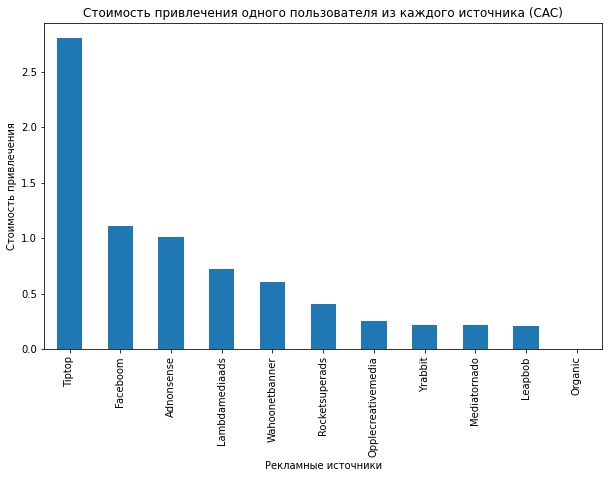

In [81]:
# Создание столбчатого графика
channel_stat.plot(kind='bar', figsize=(10, 6))

# Добавление заголовка и меток
plt.title('Стоимость привлечения одного пользователя из каждого источника (CAC)')
plt.xlabel('Рекламные источники')
plt.ylabel('Стоимость привлечения')

# Отображение графика
plt.show()

**Стоимость привлечения за одного пользователя больше всего у Tiptop, на втором месте Faceboom**

**Вывод по разделу**

**На рекламу компания потратила 105 497.3 долларов**

**Больше всего компания потратила на пользователей из источника** :  Tiptop и Faceboom. На  Tiptop ушел 51% от всех рекламных трат, на Faceboom 30 процентов от всего рекламного бюджета.

**Расходы на пользователей существенно растут у Tiptop с каждым месяцем.**  На втором месте по графику Faceboom

**Стоимость привлечения за одного пользователя больше всего у Tiptop, на втором месте Faceboom**. CAC для рекламного канала Tiptop в 4 раза превышает средний CAC по всем каналам

## Окупаемость рекламы

**Момент анализа -** 1 ноября 2019 года

**Горизонт анализа -** 2 недели


Органических пользователей в анализ в анализ не включаем, так как они пришли органически без затрат на рекламу, а значит они уже окупились

### Окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [82]:
profiles = profiles.query('channel != "Organic"')
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,Faceboom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,Faceboom,Iphone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,Adnonsense,Pc,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,Yrabbit,Iphone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,Adnonsense,Android,France,2019-06-30,2019-06-01,True,1.008000


In [83]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

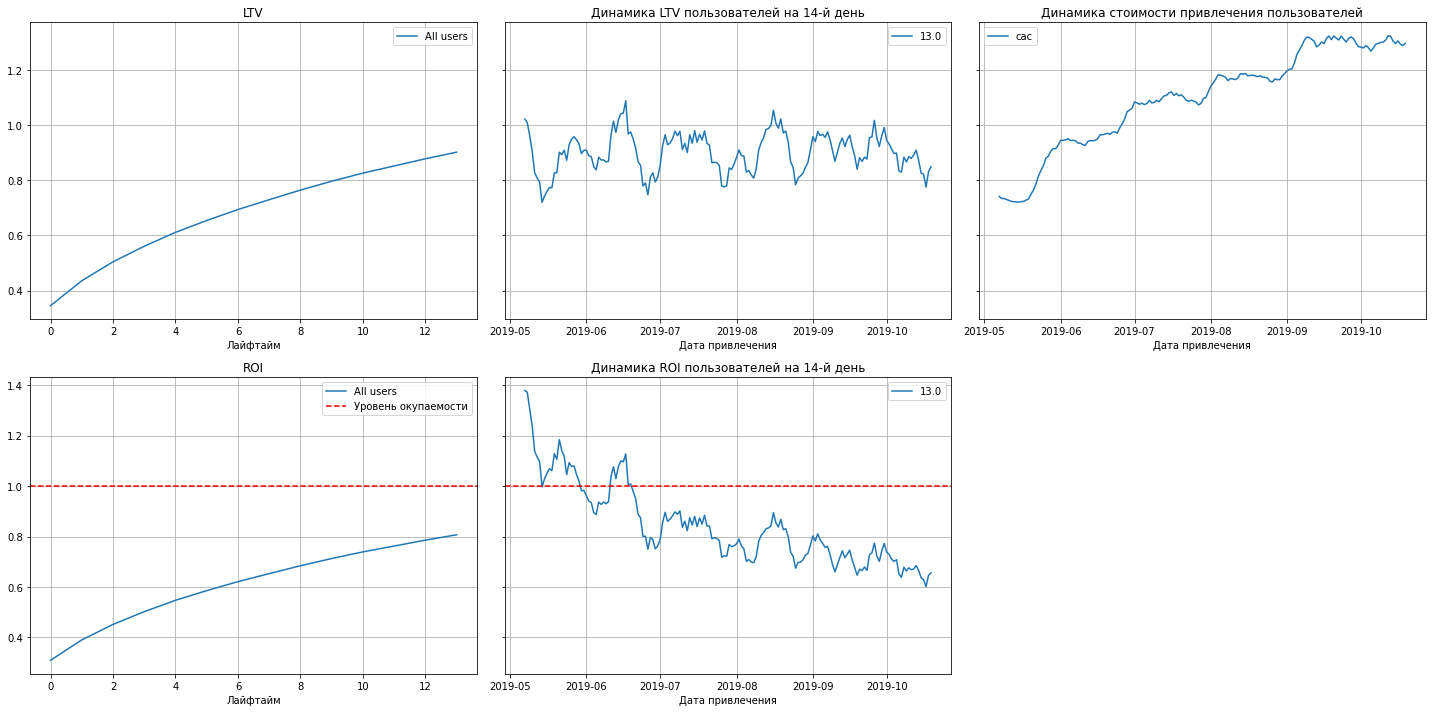

In [84]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

На основании графиков можно сделать вывод что 

**LTV**: Растет со временем, что указывает на увеличение дохода, приносимого пользователями по мере увеличения их "возраста".

**Динамика LTV пользователей на 14 день** : Показывает колебания, но без явного тренда роста или снижения, что может означать отсутствие зависимости от сезона

**CAC динамика стоимости привлечения пользователей** есть значительный скачок в стоимости привлечения клиентов начиная с июня 2019 года, что может указывать на изменение рекламной стратегии, увеличение конкуренции на рынке или повышение стоимости рекламных каналов.

**ROI** ROI на 14-й день ROI не достигает уровня окупаемости (пунктирная линия на уровне 1.0), что указывает на то, что инвестиции в привлечение пользователей не окупаются в течение первых двух недель.

**Динамика ROI на 14 день** пользователи перестаются окупаться с конца июня 2019 года 

### Конверсия пользователей и динамика её изменения.  Удержание пользователей и динамика её изменения.  Графики конверсии и удержания

Проверим конверсию пользователей и динамику её изменения.

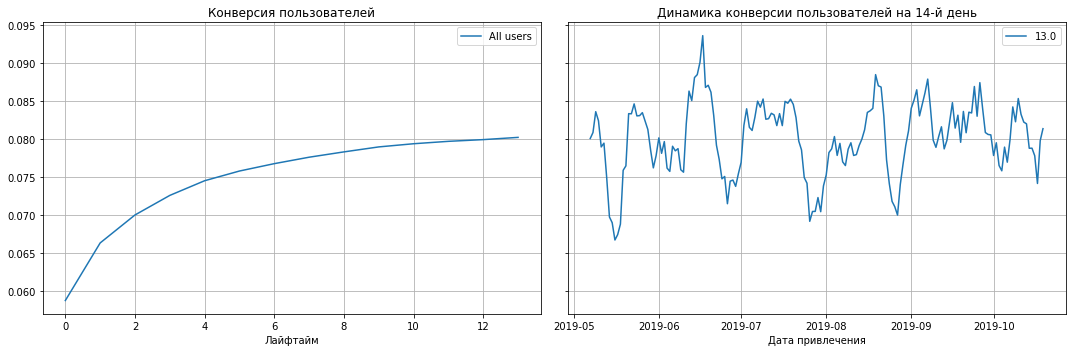

In [85]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

# Построим графики конверсии
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи конвертируются хорошо, хотя есть периодические колебания.

Проверим удержание пользователей и динамику её изменения

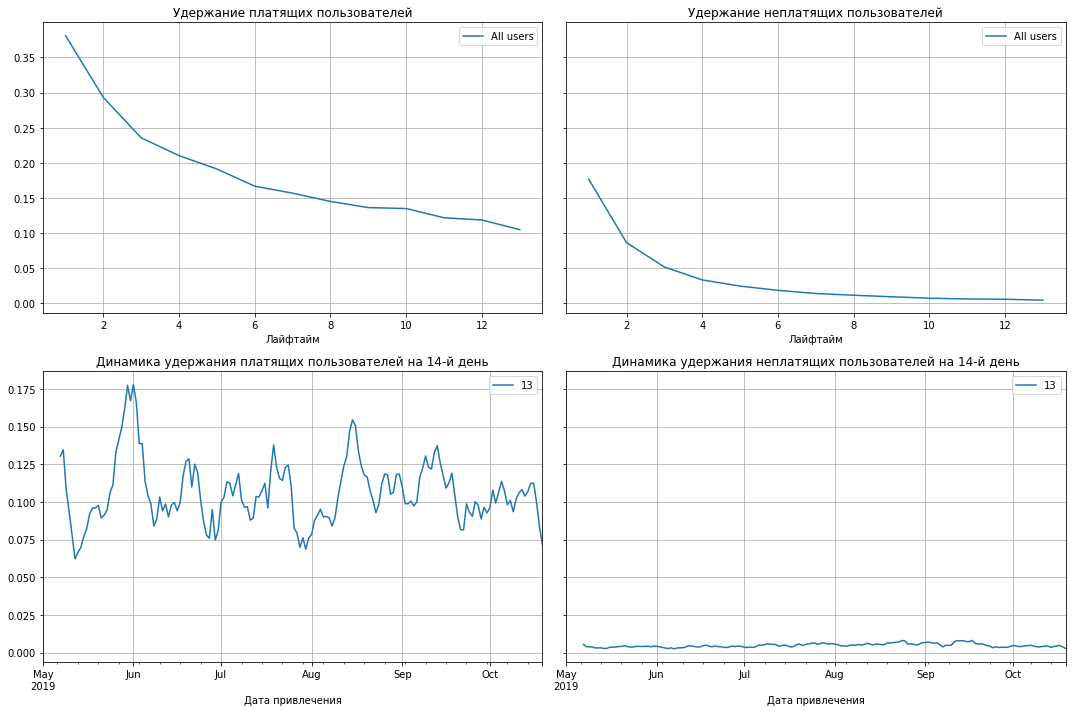

In [86]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

 #Построим графики удержания
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей выше чем неплатящих
Но можно сказать что плятящие пользователи не особо возвращаются в приложение, так как уже с 4 дня заметен сильный скачок вниз

### Окупаемость рекламы с разбивкой по устройствам.  Графики LTV и ROI, а также графики динамики LTV, CAC и ROI  и Convertion, Retention

Проанализируем окупаемость рекламы с разбивкой по устройствам.

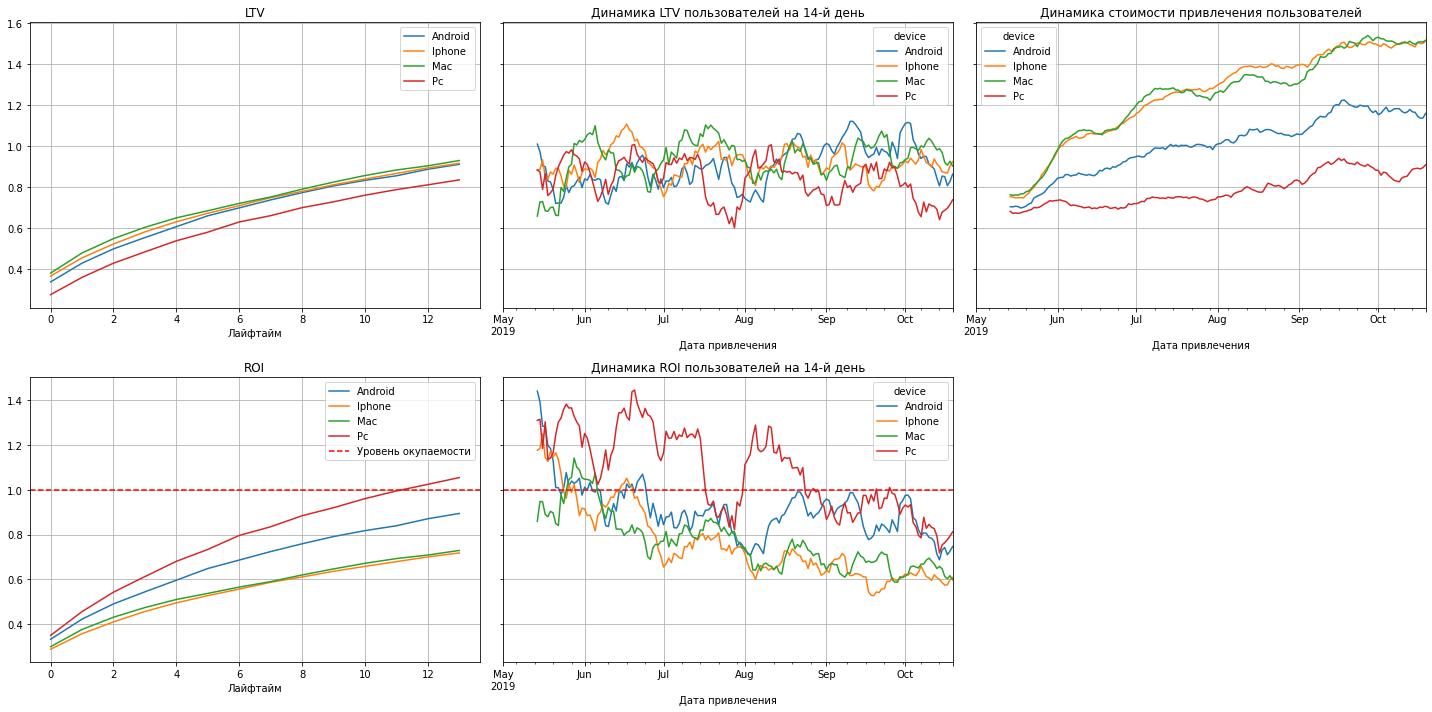

In [87]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Выручка большь всего от пользователй которые исполюзуют MAC, но и затраты на рекламу для пользователей MAC больше всего
По графику ROI можно сделать вывод что окупаются только пользователи Pc, но на этих пользователкй меньше всего и стоимость рекламы


Определим конверсию по устройствам

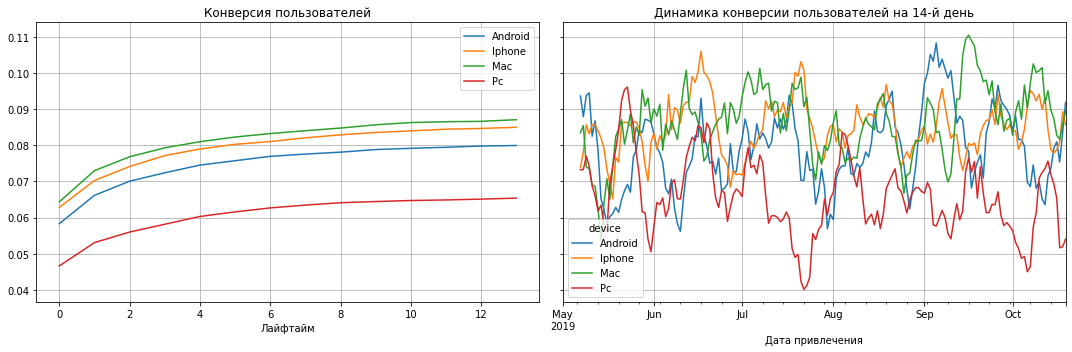

In [88]:
conversion_raw_d, conversion_grouped_d, conversion_history_d = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

# Построим графики конверсии
plot_conversion(conversion_grouped_d, conversion_history_d, horizon_days) 

 Конверсия больше всего у Mac и Iphone

Определим ретеншн по устройствам

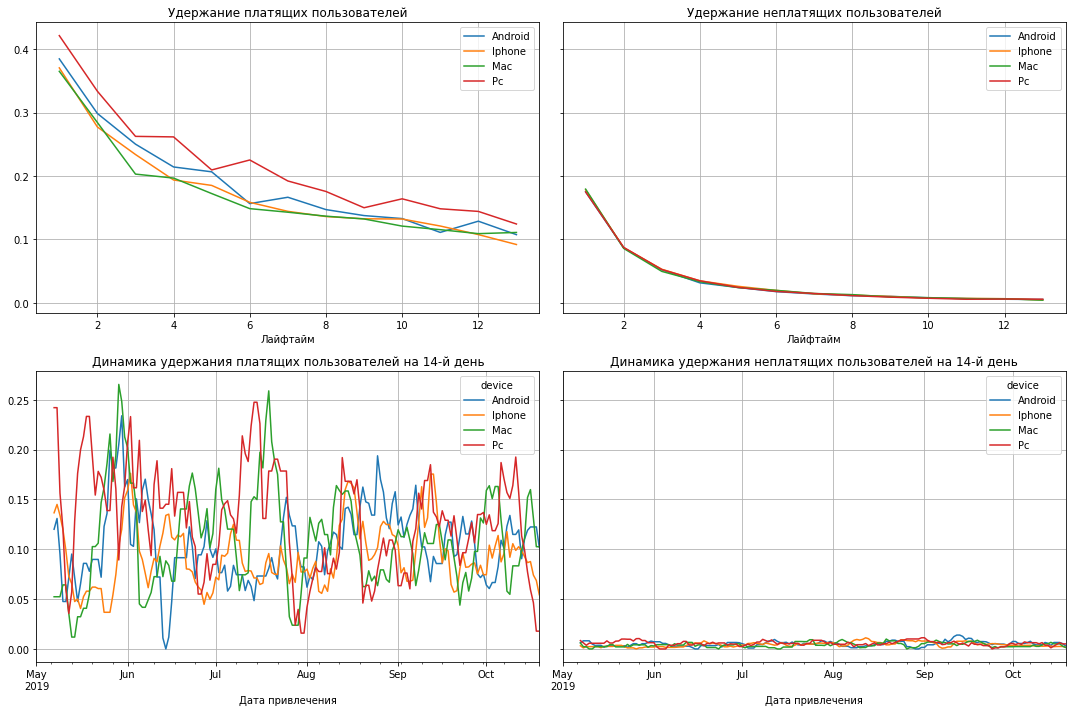

In [89]:
retention_raw_d, retention_grouped_d, retention_history_d = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

 #Построим графики удержания
plot_retention(retention_grouped_d, retention_history_d, horizon_days)

Удержание меньше всего у пользователей Mac и Iphone

### Окупаемость рекламы с разбивкой по странам.  Графики LTV и ROI, а также графики динамики LTV, CAC и ROI и Convertion, Retention

Проанализируем окупаемость рекламы с разбивкой по странам. 

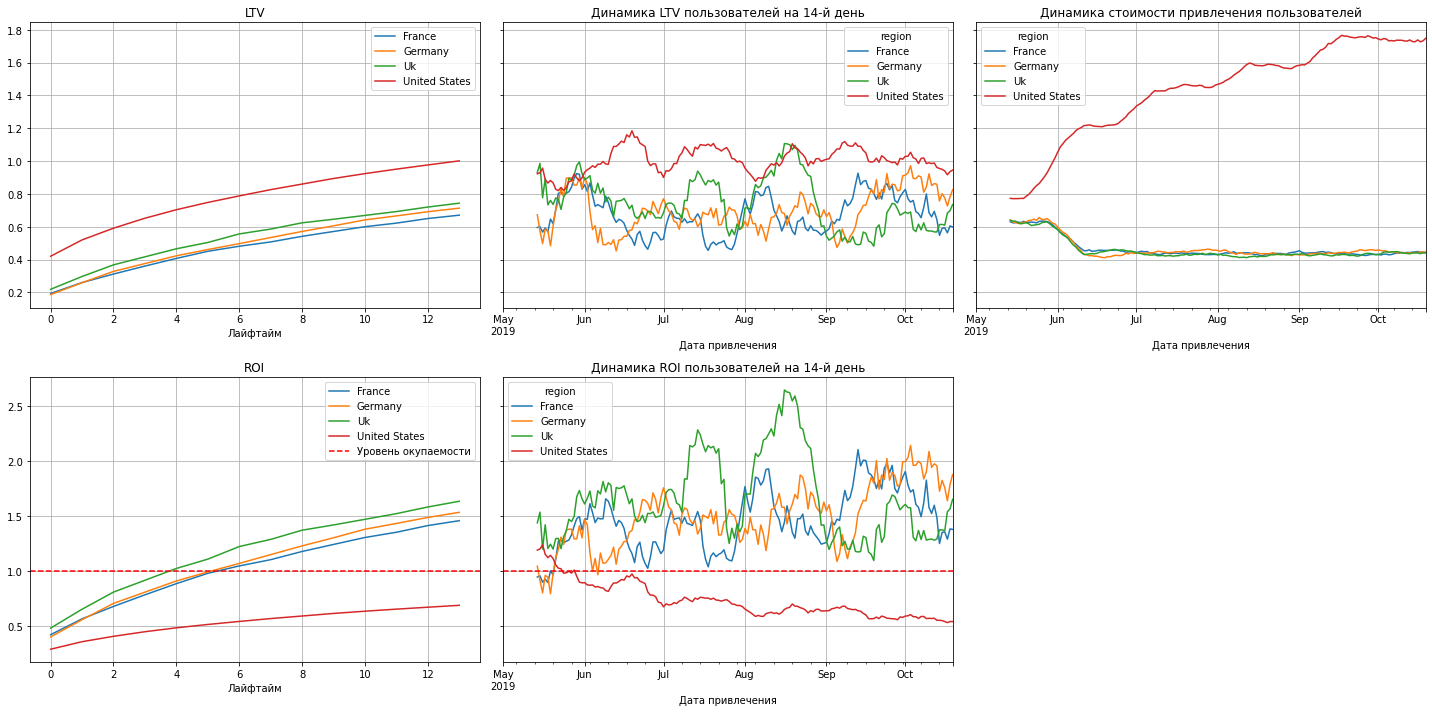

In [90]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Основываясь на полученных данных, ясно, что вложения в рекламу приносят ожидаемую отдачу во всех странах, за исключением Соединенных Штатов. В США этот показатель значительно хуже по сравнению с другими странами, что может быть обусловлено слишком высокими затратами на привлечение пользователей и недостаточной эффективностью рекламных кампаний.

Определим конверсию по странам

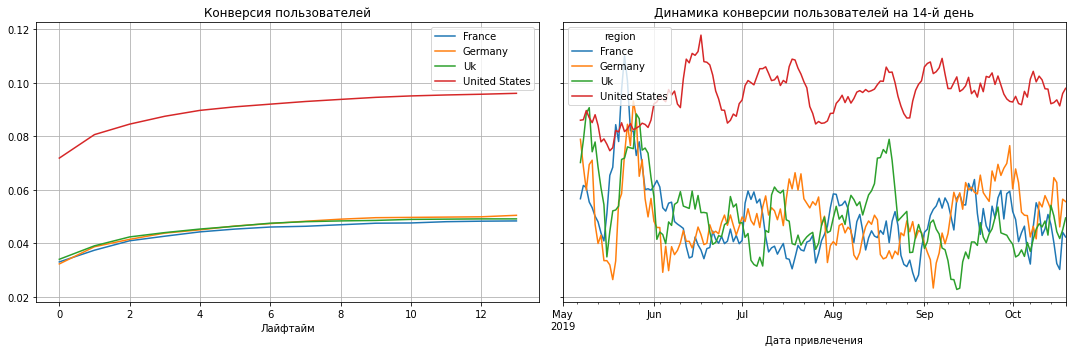

In [91]:
conversion_raw_c, conversion_grouped_c, conversion_history_c = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

# Построим графики конверсии
plot_conversion(conversion_grouped_c, conversion_history_c, horizon_days) 

Больше всего конверсия у US , хотя окупаемость меньше всех других стран

Определим ретеншн по странам

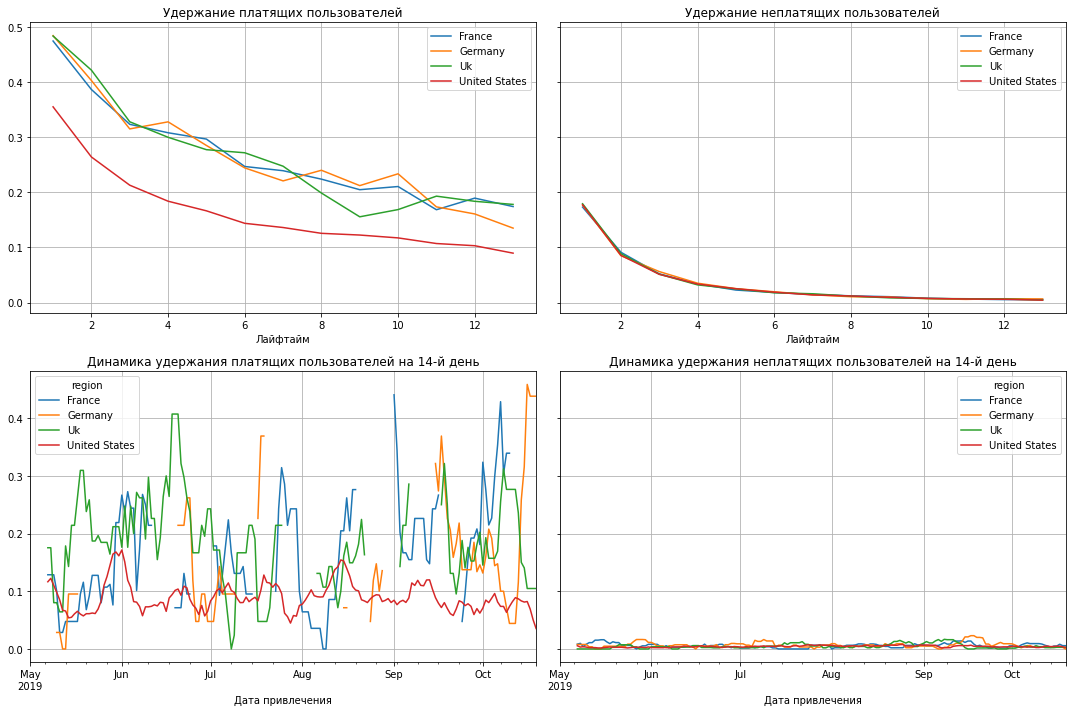

In [92]:
retention_raw_c, retention_grouped_c, retention_history_c = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

 #Построим графики удержания
plot_retention(retention_grouped_c, retention_history_c, horizon_days)

Удержание меньше всего у пользоватлей из US

### Окупаемость рекламы с разбивкой по рекламным каналам.  Графики LTV и ROI, а также графики динамики LTV, CAC и ROI и Convertion, Retention

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

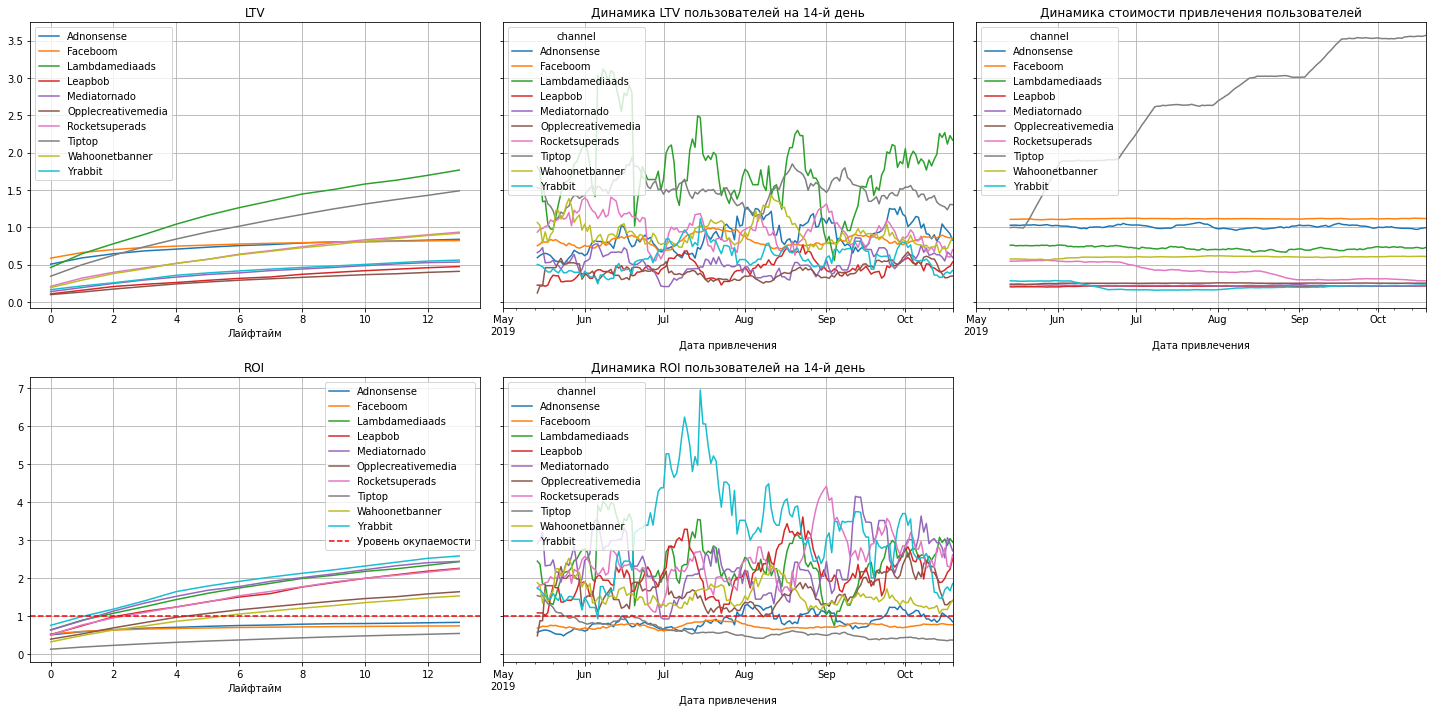

In [93]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

У канала 'TipTop', который получил наибольшее финансирование, наблюдается самый низкий уровень окупаемости инвестиций. Это подтверждается значительно высокой стоимостью привлечения клиентов и их постоянным увеличением на протяжении всего анализируемого периода.

Так же отсутствует окупаемость у пользователей привлеченных каналами Faceboom, Adnosense

Определим конверсию по каналу привлечения

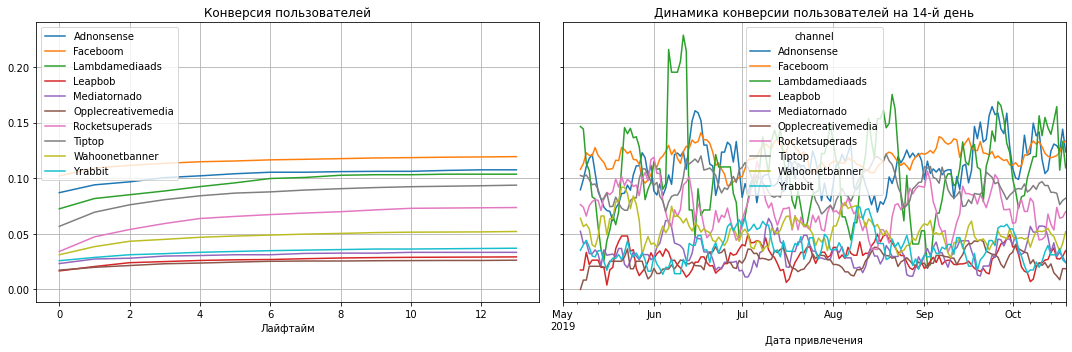

In [94]:
conversion_raw_ch, conversion_grouped_ch, conversion_history_ch = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

# Построим графики конверсии
plot_conversion(conversion_grouped_ch, conversion_history_ch, horizon_days) 

Конверсия пользователй наиболее высока у Faceboom, Adnosense, Lambdamediaads, Tiptop

Определим ретеншн по каналу привлечения

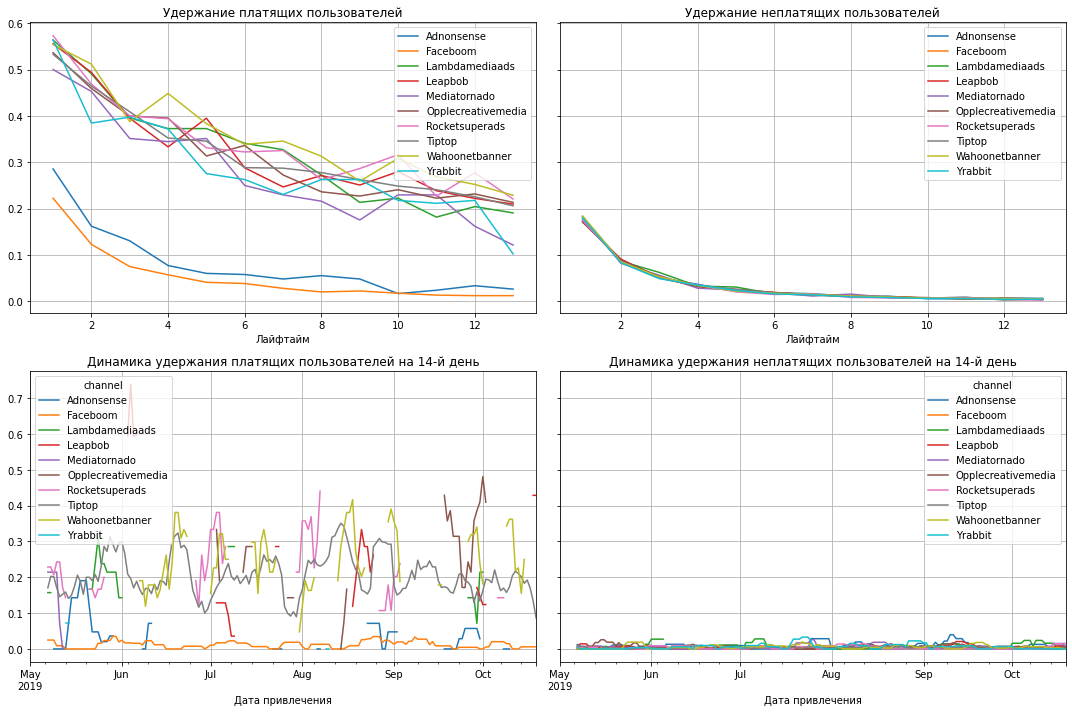

In [95]:
retention_raw_ch, retention_grouped_ch, retention_history_ch = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

 #Построим графики удержания
plot_retention(retention_grouped_ch, retention_history_ch, horizon_days)

Retention низкий у Faceboom, Adnosense

На основании проведенного анализа можно ответить на вопросы:

    1. Окупается ли реклама, направленная на привлечение пользователей в целом?
    
   Реклама оказывается неэффективной: через две недели отдача от инвестиций составляет всего лишь около 80%.
    
    2. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    Негативное влияние на окупаемость рекламы оказывают:
    
   **устройства** Mac, Iphone,
   
   **страны** US
   
   **рекламные компании** Tiptop,Faceboom, Adnosense
    
    3. Чем могут быть вызваны проблемы окупаемости?
LTV достаточно стабилен, что может говорить что выручка от пользователей не падает , а вот расходы на рекламу САС сильно увеличиваются, возможно следует сменить рекламную стратегию и выбрать другой канал привлечения

    

**Причины обнаруженных проблем:** слишком высокая стоимость привлечения одного клиента, относильно выручки от него 

**Промежуточные рекомендации для рекламного отдела:** стоит обратить внимание на рекламный источник Tiptop, потому что выручка от пользоватлей меньше чем рекламные расходы ( рекламные расходы в разы превышают другие рекламные источники)


## Общий вывод

**Причины неэффективности привлечения пользователей:**

Затраты на привлечение пользователей с устройствами **Mac и iPhone** наиболее высоки и продолжают возрастать, при этом окупаемость остается на низком уровне. Это может быть связано с низким retention из-за менее удобным интерфейсом или системой оплаты на этих платформах, хотя конверсия высока

В **США** наблюдается низкая окупаемость рекламы, несмотря на высокую долю американских пользователей. Самый высокий LTV и конверсия отмечен именно в США, что говорит о том, что американские клиенты в среднем приносят больше дохода. Однако из-за высоких затрат на привлечение клиентов вложения не оправдываются. Пользователи из США хорошо конвертируются, но удержание их оставляет желать лучшего, что может указывать на возможные проблемы в использовании приложения или на высокую конкуренцию на рынке.

Похоже, что бюджет на рекламу распределен неправильно среди каналов. Клиенты, привлеченные через **AdNonSense, FaceBoom и TipTop**, не приносят ожидаемой отдачи, хотя их привлечение стоит дорого. Несмотря на хорошую конверсию в FaceBoom и AdNonSense, удержание клиентов слабое. Это означает, что высокой конверсии недостаточно для окупаемости из-за завышенной стоимости рекламы.

**Рекомендации для отдела маркетинга**

Нужно пересмотреть стратегию для владельцев Mac и iPhone, так как высокие затраты на их привлечение не оправдываются низкой окупаемостью. Возможно, стоит улучшить маркетинг для них и проверить наличие технических проблем.

Также важно перебалансировать рекламные расходы, особенно в США, где дорогие каналы не окупаются. Лучше инвестировать в более эффективные и дешевые каналы и уменьшить расходы на TipTop и FaceBoom. 

Надо разобраться с причинами падения окупаемости с июня и перенаправить усилия на более прибыльные рынки, например, в Англии и Германии.

Анализ по региональному признаку (Европа и США) выявил, что в Европе рекламные кампании эффективны, в отличие от крупнейшего рынка — США. Несмотря на значительные вложения, каналы TipTop и FaceBoom так и не достигли уровня окупаемости. Перераспределение рекламного бюджета в пользу каналов YRabbit,Leapbob, MediaTornado и RocketSuperAds может быть хорошей тактикой.

В целом, нужно искать способы улучшения удержания и монетизации пользователей, чтобы обеспечить окупаемость инвестиций в рекламу.